# Predict car license number from licence plate image

In [1]:
import os
import random
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import load_model
from label_codec import LabelCodec

print ("TensorFlow Version: {}".format(tf.__version__))

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

TensorFlow Version: 2.1.0-rc2
GPU device: /device:GPU:0


In [2]:
from config import config

# input size
IMAGE_WIDTH = config.IMAGE_WIDTH
IMAGE_HEIGHT = config.IMAGE_HEIGHT

MAX_TEXT_LEN = config.MAX_TEXT_LEN

OUTPUT_PATH = config.OUTPUT_PATH
OPTIMIZER = config.OPTIMIZER
MODEL_NAME = config.MODEL_NAME

MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".h5"
TEST_IMAGES = config.TEST_IMAGES

print("Image Size:   ({}, {})".format(IMAGE_WIDTH, IMAGE_HEIGHT))
print("Model Name:   {}".format(MODEL_NAME))
print("Model path:   {}".format(MODEL_PATH))

Image Size:   (128, 64)
Model Name:   glpr-model
Model path:   output\rmsprop\glpr-model.h5


In [3]:
def load_image(filepath):
    stream = open(filepath, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    image = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

    # convert image to grayscale, if it is not already a grayscale image
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return image


def show_image(image):
    plt.axis("off")
    plt.title(label)
    plt.imshow(image, cmap='gray')
    plt.show()

In [4]:
tf.compat.v1.disable_eager_execution()
model = load_model(MODEL_PATH, compile=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


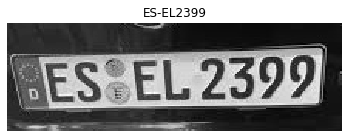

Predicted: ES-EL2399
True:      ES-EL2399
=> True


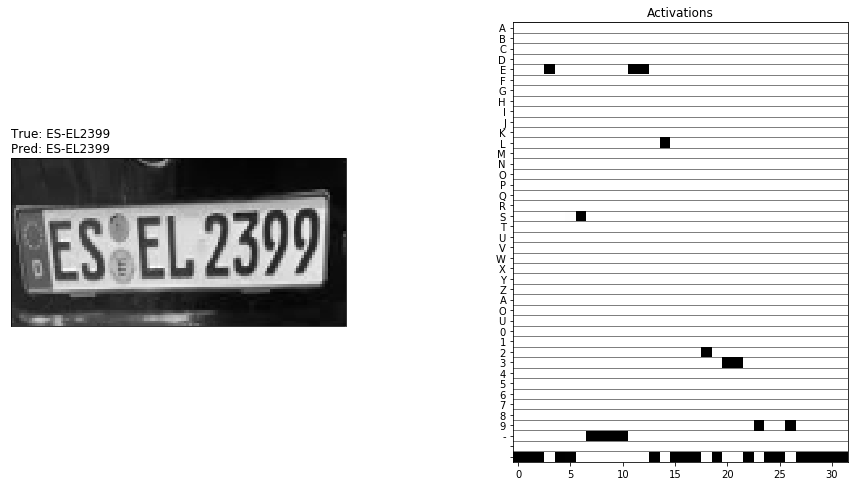

In [29]:
img_filename = random.choice(os.listdir(TEST_IMAGES))
img_filepath = os.path.join(TEST_IMAGES, img_filename)
label = img_filename.split(".")[0].split("#")[0]
image = load_image(img_filepath)

# original image
show_image(image)

# predict
image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)
image = image.astype(np.float32) / 255.
image = np.expand_dims(image.T, -1)

prediction = model.predict(image)
pred_number = LabelCodec.decode_number(prediction)

fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(1, 2, wspace=.5, hspace=0.1)
ax1 = plt.Subplot(fig, outer[0])
fig.add_subplot(ax1)
print('Predicted: %9s\nTrue:      %9s\n=> %s' % (pred_number, label, pred_number == label))
image = image[:, :, 0].T
ax1.set_title('True: {}\nPred: {}'.format(label, pred_number), loc='left')
ax1.imshow(image, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.Subplot(fig, outer[1])
fig.add_subplot(ax2)
ax2.set_title('Activations')
ax2.imshow(predictions[0].T, cmap='binary', interpolation='nearest')
ax2.set_yticks(list(range(len(LabelCodec.ALPHABET) + 1)))
ax2.set_yticklabels(LabelCodec.ALPHABET)  # + ['blank'])
ax2.grid(False)
for h in np.arange(-0.5, len(LabelCodec.ALPHABET) + 1 + 0.5, 1):
    ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)